# Data collection and descriptive analysis
From [Open Food Facts](https://world.openfoodfacts.org/) we have a 1.7 GB `.csv` file which contains information of over 600 000 unique food products. Our purpose with this notebook is to explore this dataset and compile the availible information into one/several files of a smaller format containing only what is needed and can be used for our project.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data_folder = "./data/"

In [3]:
database = pd.read_csv(data_folder + "en.openfoodfacts.org.products.csv", sep='\t', dtype=object)

We take a look at the data:

In [4]:
database.describe()

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,...,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g,choline_100g,phylloquinone_100g,beta-glucan_100g,inositol_100g,carnitine_100g
count,696770,696770,696801,696800,696794,696804,696804,670800,77415,194249,...,344,140760,140760,2,1,27,1,14,33,13
unique,696731,696733,6656,562201,562207,551516,551515,479331,58231,22537,...,211,56,56,2,1,18,1,10,19,8
top,3760090081828,http://world-en.openfoodfacts.org/product/3350...,kiliweb,1489055829,2017-03-09T10:37:09Z,France,en:france,Comté,Pâtes alimentaires au blé dur de qualité supér...,500 g,...,0,0,0,3,2,0.069,1.6e-05,4,0.02,0.0073
freq,2,2,312135,20,20,29,31,451,181,7881,...,82,7338,10150,1,1,4,1,3,6,2


We have a lot of different types of data, 173 columns. This means that the `describe` method does not really give us information that is easy to survey - we need to explore the data in another way. 

# Finding the column with the country data
We are interested in doing out analysis based on which country the food item comes from. We therefore filter the data to find the columns which starts with the string `countr` for "countries":

In [5]:
filter_col = [col for col in database if col.startswith('countr')]
filter_col

['countries', 'countries_tags', 'countries_en']

We have three different columns regarding country data. Let's try to find out which one is relevant for us. A guess is that it is the `countries_en` column that we need, since the name presumably means that the column contain data of the origin country in English.

Looking at the `countries` column, we notice that there are duplicates:

In [6]:
database.countries.value_counts().head(5)

en:france    205162
France       179274
US           168473
en:FR         28054
Suisse         9097
Name: countries, dtype: int64

France appears several times! By comparing the number of unique values for each of the three different columns we see that the other two columns contain less than half the number of unique values:

In [7]:
for col in filter_col:
    print("Number of unique country labels in column '{}': ".format(col) + str(database[col].value_counts().shape[0]))


Number of unique country labels in column 'countries': 3227
Number of unique country labels in column 'countries_tags': 1227
Number of unique country labels in column 'countries_en': 1227


Taking a look at `countries_tags` and `countries_en` gives us the information that they are basically identical, just with a different format for each country:

In [8]:
database.countries_tags.value_counts().head(6)

en:france               421492
en:united-states        173575
en:switzerland           13463
en:germany               11845
en:france,en:germany      6309
en:spain                  6234
Name: countries_tags, dtype: int64

In [9]:
database.countries_en.value_counts().head(6)

France            421492
United States     173575
Switzerland        13463
Germany            11845
France,Germany      6309
Spain               6234
Name: countries_en, dtype: int64

Because of this, we decide to use the `countries_en` column. We note the format of the column, that each country starts with a capital letter and that if there are several countries they are separated by a comma without and whitespace.

# Filtering out France and the United States
We are only interested in comparing France against the United States. Because of this, we want to compile the rows of the database which contain data for these two countries into two new dataframes respectively.

In [10]:
# na=False drops all the rows where countries_en is NaN
france_data = database[database.countries_en.str.contains("France", na=False)]
us_data = database[database.countries_en.str.contains("United States", na=False)]

# Filtering out relevant columns

Relevant columns are columns with values for several products. We define that a column is relevant to look at if it has at least 10 000 defined values.

In [11]:
columns10000 = ((france_data.count() > 10000) & (us_data.count() > 10000))

In [12]:
france_data.columns[columns10000]

Index(['code', 'url', 'creator', 'created_t', 'created_datetime',
       'last_modified_t', 'last_modified_datetime', 'product_name', 'brands',
       'brands_tags', 'countries', 'countries_tags', 'countries_en',
       'ingredients_text', 'serving_size', 'serving_quantity', 'additives_n',
       'additives', 'additives_tags', 'additives_en',
       'ingredients_from_palm_oil_n',
       'ingredients_that_may_be_from_palm_oil_n', 'states', 'states_tags',
       'states_en', 'energy_100g', 'fat_100g', 'saturated-fat_100g',
       'carbohydrates_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g',
       'salt_100g', 'sodium_100g'],
      dtype='object')

From the resultig columns, we will use the ones relevant for nutrition. These are the ones with values per 100g, servings and the product names. In addition to these, we will save the column "category", as we will use it to categorise our data. We will also save some additional vitamins and minerals, as well as two columns with nutrition facts. An overview of all columns can be found here: https://static.openfoodfacts.org/data/data-fields.txt

In [13]:
re_columns = ['product_name', 'brands', 'brands_tags', 'ingredients_text', 'serving_size', 'categories',
              'categories_tags', 'categories_en',
              'serving_quantity', 'energy_100g', 'proteins_100g', 'carbohydrates_100g', 'sugars_100g', 'fat_100g',
              'saturated-fat_100g','monounsaturated-fat_100g', 'polyunsaturated-fat_100g', 'omega-3-fat_100g',
              'omega-6-fat_100g','omega-9-fat_100g', 'trans-fat_100g', 'cholesterol_100g', 'fiber_100g',
              'sodium_100g', 'vitamin-a_100g','vitamin-d_100g', 'vitamin-e_100g', 'vitamin-k_100g', 'vitamin-c_100g',
              'vitamin-b1_100g','vitamin-b2_100g', 'vitamin-pp_100g', 'vitamin-b6_100g', 'vitamin-b9_100g',
              'vitamin-b12_100g',
              'biotin_100g', 'calcium_100g', 'phosphorus_100g', 'iron_100g', 'magnesium_100g', 'zinc_100g',
              'copper_100g', 'manganese_100g', 'fluoride_100g', 'selenium_100g', 'chromium_100g', 'molybdenum_100g',
              'iodine_100g', 'nutrition-score-fr_100g', 'nutrition-score-uk_100g']

In [33]:
france = france_data[re_columns]
usa = us_data[re_columns]
france = france.reset_index(drop=True)
usa = usa.reset_index(drop=True)
france.to_csv(data_folder + 'france.csv')
usa.to_csv(data_folder + 'usa.csv')

# Data: statistically

In [3]:
france = pd.read_csv(data_folder + 'france.csv')
usa = pd.read_csv(data_folder + 'usa.csv')

In [4]:
# number of products
print("There are %d products sold in France" % len(france))
print("There are %d products sold in the USA" % len(usa))

There are 448849 products sold in France
There are 175507 products sold in the USA


In [20]:
france.describe()

,Unnamed: 0,serving_quantity,energy_100g,proteins_100g,carbohydrates_100g,sugars_100g,fat_100g,saturated-fat_100g,monounsaturated-fat_100g,polyunsaturated-fat_100g,...,zinc_100g,copper_100g,manganese_100g,fluoride_100g,selenium_100g,chromium_100g,molybdenum_100g,iodine_100g,nutrition-score-fr_100g,nutrition-score-uk_100g
count,448849.000000,4.400330e+05,3.872380e+05,386946.000000,382118.000000,385843.000000,382416.000000,385719.000000,1906.000000,1933.000000,...,404.000000,212.000000,201.000000,139.000000,1.700000e+02,24.000000,14.000000,213.000000,117397.000000,117397.000000
mean,224424.000000,1.824768e+01,1.154168e+03,8.441789,27.786416,14.135229,13.649431,5.260408,19.862718,10.518795,...,0.049028,0.184212,0.047529,0.006745,9.080445e-02,0.000151,0.000305,0.197496,9.558285,8.916872
std,129571.689825,3.921480e+03,3.906166e+03,13.310373,126.082414,113.046427,17.526552,12.038681,23.399851,15.647743,...,0.405326,2.582312,0.370758,0.049131,1.071578e+00,0.000610,0.000996,2.173698,8.835124,9.349267
min,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,-0.100000,0.000000,0.000000,0.000000,0.000000,...,0.000060,0.000000,0.000000,0.000000,2.500000e-08,0.000002,0.000005,0.000000,-15.000000,-15.000000
25%,112212.000000,0.000000e+00,4.480000e+02,1.300000,2.900000,0.700000,0.900000,0.200000,2.500000,1.500000,...,0.001175,0.000188,0.000054,0.000025,3.562500e-06,0.000010,0.000016,0.000016,2.000000,1.000000
50%,224424.000000,0.000000e+00,1.088000e+03,5.900000,14.000000,3.700000,7.100000,1.900000,9.100000,3.800000,...,0.002450,0.000344,0.000500,0.000120,1.265000e-05,0.000013,0.000032,0.000047,10.000000,8.000000
75%,336636.000000,0.000000e+00,1.669000e+03,12.000000,53.000000,20.000000,21.500000,7.500000,27.000000,12.000000,...,0.005300,0.000810,0.001400,0.000500,2.787500e-05,0.000027,0.000046,0.000100,16.000000,17.000000
max,448848.000000,2.601059e+06,1.841546e+06,4400.000000,72000.000000,68000.000000,915.000000,5555.000000,82.000000,75.000000,...,5.700000,37.600000,4.000000,0.560000,1.390000e+01,0.003010,0.003760,29.000000,40.000000,39.000000


The description table shows that there are several columns where the amount of nutriment is more than 100. We will convert all values above 100 to NaN since we consider these to be incorrect values. We will only keep the values for `energy_100g` and `carbohydrates_100g` as these are in the unit kilojoule.

In [14]:
usa.max()

Unnamed: 0                  175506.000000
serving_quantity              2091.000000
energy_100g                 231199.000000
proteins_100g                 3330.000000
carbohydrates_100g           10400.000000
sugars_100g                  10000.000000
fat_100g                      1880.000000
saturated-fat_100g             612.000000
monounsaturated-fat_100g      1250.000000
polyunsaturated-fat_100g       417.000000
omega-3-fat_100g                 4.900000
omega-6-fat_100g                 0.238000
omega-9-fat_100g                      NaN
trans-fat_100g                 369.000000
cholesterol_100g                95.238000
fiber_100g                    5380.000000
sodium_100g                  40000.000000
vitamin-a_100g                   4.000000
vitamin-d_100g                   0.005000
vitamin-e_100g                   0.044100
vitamin-k_100g                  31.250000
vitamin-c_100g                 716.981100
vitamin-b1_100g                139.000000
vitamin-b2_100g                 42

In [18]:
(usa.carbohydrates_100g[usa.energy_100g > 100]).count()

157582

161211

,index,product_name,brands,brands_tags,ingredients_text,serving_size,categories,categories_tags,categories_en,serving_quantity,...,zinc_100g,copper_100g,manganese_100g,fluoride_100g,selenium_100g,chromium_100g,molybdenum_100g,iodine_100g,nutrition-score-fr_100g,nutrition-score-uk_100g
0,0,Vitória crackers,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,Cacao,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,Sauce Sweety chili 0%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,Mini coco,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,Mendiants,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


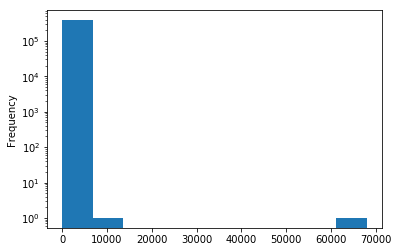

In [29]:
hmm = france.sugars_100g
hmm = hmm.dropna()
hmm = pd.to_numeric(hmm)

#hmm.plot(kind='hist', logy=True, logx='True')
hmm.plot(kind='hist', logy=True)

/anaconda3/envs/ada/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


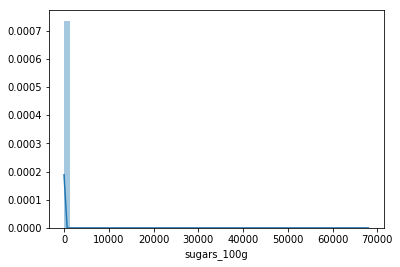

In [17]:
sns.distplot(hmm)